In [16]:
library(rethinking)

In [17]:
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

# Regression with home goals

Start with a regression with home goals and away goals.

Model:

$$goals_i \thicksim Poission(\lambda_i)$$

$$log (\lambda_i) = \alpha_i[team] + \beta_{home}*hemma$$

$$\alpha_{team} \thicksim N(0, 10)$$

$$\beta_{home} \thicksim N(0,10)$$



construct a frame with (date), team, goals, home/away


In [18]:
library(dplyr)
df <- read.csv('2017_2018.csv')


df_hemma <- select(df, 1,2,4)
df_hemma$hemma <- 1
colnames(df_hemma) <- c("date", "team", "goals", "home")

df_borta <- select(df, 1, 3, 6)
df_borta$hemma <- 0
colnames(df_borta) <- c("date", "team", "goals", "home")


df <- rbind(df_hemma, df_borta)
df[, "team"]<- as.factor(df[,"team"])
df[, "date"] <- as.Date(df[, "date"], format = "%Y-%m-%d")
str(df)

'data.frame':	198 obs. of  4 variables:
 $ date : Date, format: "2017-10-28" "2017-10-28" ...
 $ team : Factor w/ 14 levels "Brynäs","Djurgården",..: 13 9 14 11 12 3 4 10 2 8 ...
 $ goals: int  1 3 2 1 1 2 4 3 2 1 ...
 $ home : num  1 1 1 1 1 1 1 1 1 1 ...


In [7]:
mean_goals <- df %>% group_by(team, home) %>% summarize(mean_goals = mean(goals), var_goals = var(goals))
mean_goals

team,home,mean_goals,var_goals
Brynäs,0,2.000000,1.333333
Brynäs,1,1.857143,1.809524
Djurgården,0,2.428571,2.952381
Djurgården,1,3.142857,2.476190
Färjestad,0,3.500000,1.714286
Färjestad,1,3.571429,3.619048
Frölunda,0,2.833333,1.366667
Frölunda,1,2.625000,1.982143
HV71,0,2.250000,1.357143
HV71,1,2.571429,2.619048


In [31]:
teams_no <- sort(as.numeric(unique(df$team)))
teams_no

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14

In [32]:
teams <- sort(unique(df$team))
teams

[1] Brynäs     Djurgården Färjestad  Frölunda   HV71       Karlskrona
 [7] Linköping  Luleå      Malmö      Mora       Örebro     Rögle     
[13] Skellefteå Växjö     
14 Levels: Brynäs Djurgården Färjestad Frölunda HV71 Karlskrona ... Växjö

$$goals_i \thicksim Poission(\mu_i)$$

$$log (\mu_i) = \alpha + \alpha_i[team] + \beta_i*hemma$$

$$\alpha_{team} \thicksim N(\alpha,\sigma_a)$$

$$\beta_{team} \thicksim N(\beta,\sigma_b)$$

$$\alpha \thicksim N(0,7)$$

$$\beta \thicksim N(0,7)$$

$$\sigma_a \thicksim HalfCauchy(0,1)$$

$$\sigma_b \thicksim HalfCauchy(0,1)$$

In [42]:
library(rethinking)

m2 <- map2stan(
    alist(
        goals ~ dpois(lambda),
        log(lambda) <- alpha[team] + beta*home,
        alpha[team] ~ dnorm(1,1),
        beta ~ dnorm(0,1)
    ),
    data = df,
    iter = 5000,
    warmup = 2000,
    chains = 2
)

In file included from /opt/conda/lib/R/library/BH/include/boost/config.hpp:39:0,
                 from /opt/conda/lib/R/library/BH/include/boost/math/tools/config.hpp:13,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file586d14f3b5.cpp:8:
/opt/conda/lib/R/library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_REFERENCES
 ^
<command-line>:0:0: note: this is t

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Computing WAIC
Constructing posterior predictions


[ 6000 / 6000 ]


In [61]:
m2

map2stan model fit
6000 samples from 2 chains

Formula:
goals ~ dpois(lambda)
log(lambda) <- alpha[team] + beta * home
alpha[team] ~ dnorm(1, 1)
beta ~ dnorm(0, 1)

Log-likelihood at expected values: -364.42 
Deviance: 728.84 
DIC: 757.92 
Effective number of parameters (pD): 14.54 

WAIC (SE): 760.54 (22.1)
pWAIC: 15.96 

In [44]:
m3 <- map2stan(
    alist(
        goals ~ dpois(lambda),
        log(lambda) <- alpha[team] + beta*home,
        alpha[team] ~ dnorm(mu_a,sigma_a),
        beta ~ dnorm(mu_b,sigma_b),
        mu_a ~ dnorm(1,1),
        mu_b ~ dnorm(0,1),
        sigma_a ~ dcauchy(0,1),
        sigma_b ~ dcauchy(0,1)
    ),
    data = df,
    iter = 5000,
    warmup = 2000,
    chains = 2
)

In file included from /opt/conda/lib/R/library/BH/include/boost/config.hpp:39:0,
                 from /opt/conda/lib/R/library/BH/include/boost/math/tools/config.hpp:13,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file58661ae5882.cpp:8:
/opt/conda/lib/R/library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_REFERENCES
 ^
<command-line>:0:0: note: this is 

Warning message:
“There were 1282 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


SAMPLING FOR MODEL 'goals ~ dpois(lambda)' NOW (CHAIN 1).

Gradient evaluation took 0.00024 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.4 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 1e-06 seconds (Warm-up)
               0.000749 seconds (Sampling)
               0.00075 seconds (Total)



Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Computing WAIC
Constructing posterior predictions


[ 6000 / 6000 ]


Warning message in map2stan(alist(goals ~ dpois(lambda), log(lambda) <- alpha[team] + :
“There were 1282 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”

In [45]:
precis(m3)

Warning message in precis(m3):
“There were 1282 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”14 vector or matrix parameters omitted in display. Use depth=2 to show them.


        Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
beta    0.14   0.10      -0.01       0.28     7 1.29
mu_a    0.86   0.08       0.73       0.97    13 1.10
mu_b    0.10   0.54      -0.77       0.93  1988 1.00
sigma_a 0.13   0.09       0.01       0.24     6 1.32
sigma_b 1.00   1.22       0.03       1.82   796 1.00

In [46]:
precis(m3, depth = 2)

Warning message in precis(m3, depth = 2):
“There were 1282 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”

          Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
alpha[1]  0.78   0.16       0.53       0.96     8 1.19
alpha[2]  0.89   0.11       0.72       1.08   318 1.01
alpha[3]  0.99   0.12       0.82       1.20    33 1.05
alpha[4]  0.88   0.12       0.67       1.05    35 1.04
alpha[5]  0.85   0.12       0.64       1.00    14 1.10
alpha[6]  0.69   0.21       0.39       0.95     6 1.25
alpha[7]  0.86   0.12       0.66       1.03    25 1.05
alpha[8]  0.79   0.14       0.57       0.97     8 1.19
alpha[9]  0.90   0.11       0.69       1.06  1424 1.01
alpha[10] 0.83   0.13       0.62       1.01    15 1.09
alpha[11] 0.86   0.12       0.66       1.02    16 1.07
alpha[12] 0.85   0.12       0.64       1.01    25 1.06
alpha[13] 0.98   0.12       0.81       1.19   101 1.03
alpha[14] 0.92   0.11       0.73       1.11  1405 1.00
beta      0.14   0.10      -0.01       0.28     7 1.29
mu_a      0.86   0.08       0.73       0.97    13 1.10
mu_b      0.10   0.54      -0.77       0.93  1988 1.00
sigma_a   

Waiting to draw page 2 of 2


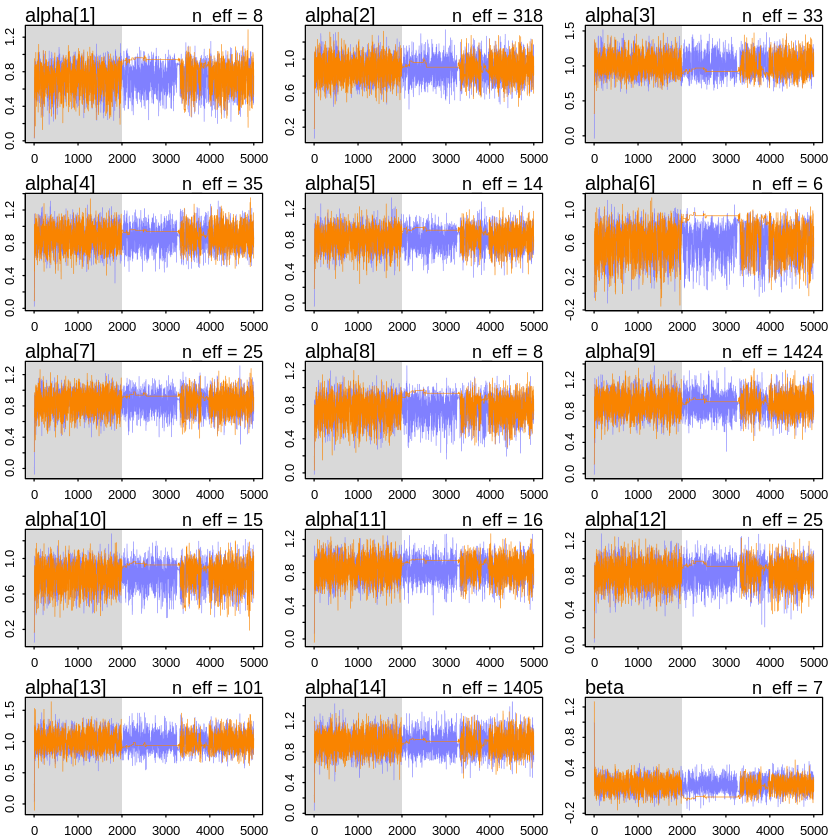

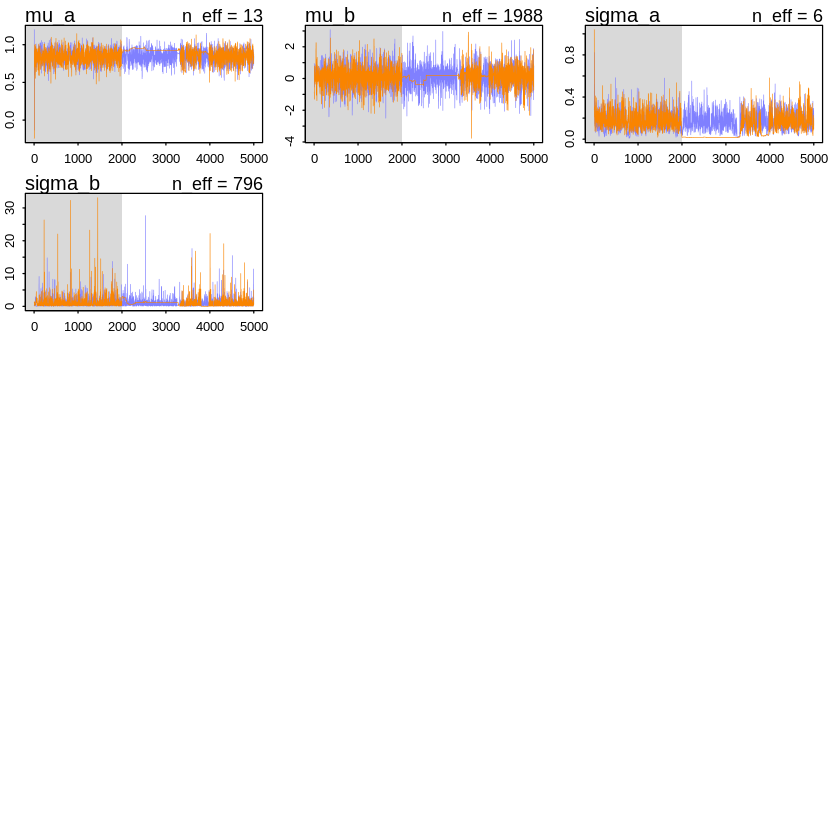

In [47]:
plot(m3)

In [48]:
exp(coef(m3))

alpha[1]  alpha[2]  alpha[3]  alpha[4]  alpha[5]  alpha[6]  alpha[7]  alpha[8] 
 2.176768  2.441977  2.703330  2.418861  2.331542  1.999400  2.366893  2.209261 
 alpha[9] alpha[10] alpha[11] alpha[12] alpha[13] alpha[14]      beta      mu_a 
 2.458123  2.304040  2.368364  2.349617  2.663401  2.506008  1.145196  2.371992 
     mu_b   sigma_a   sigma_b 
 1.110406  1.136778  2.718011

In [49]:
summary(m3)

Inference for Stan model: goals ~ dpois(lambda).
2 chains, each with iter=5000; warmup=2000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=6000.

            mean se_mean    sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
alpha[1]    0.78    0.06  0.16   0.42   0.67   0.80   0.93   0.98     8 1.19
alpha[2]    0.89    0.01  0.11   0.65   0.83   0.90   0.96   1.12   318 1.01
alpha[3]    0.99    0.02  0.12   0.78   0.92   0.97   1.07   1.28    33 1.05
alpha[4]    0.88    0.02  0.12   0.63   0.81   0.91   0.95   1.11    35 1.04
alpha[5]    0.85    0.03  0.12   0.57   0.77   0.87   0.93   1.04    14 1.10
alpha[6]    0.69    0.08  0.21   0.26   0.55   0.71   0.89   0.95     6 1.25
alpha[7]    0.86    0.02  0.12   0.60   0.79   0.89   0.93   1.06    25 1.05
alpha[8]    0.79    0.05  0.14   0.46   0.70   0.81   0.93   0.97     8 1.19
alpha[9]    0.90    0.00  0.11   0.66   0.84   0.92   0.95   1.14  1424 1.01
alpha[10]   0.83    0.03  0.13   0.52   0.76   0.87   0.93   1.

In [50]:
compare(m2,m3)

    WAIC pWAIC dWAIC weight    SE  dSE
m3 757.3   9.4   0.0   0.84 23.18   NA
m2 760.5  16.0   3.3   0.16 22.06 6.96

In [51]:
m2

map2stan model fit
6000 samples from 2 chains

Formula:
goals ~ dpois(lambda)
log(lambda) <- alpha[team] + beta * home
alpha[team] ~ dnorm(1, 1)
beta ~ dnorm(0, 1)

Log-likelihood at expected values: -364.42 
Deviance: 728.84 
DIC: 757.92 
Effective number of parameters (pD): 14.54 

WAIC (SE): 760.54 (22.1)
pWAIC: 15.96 

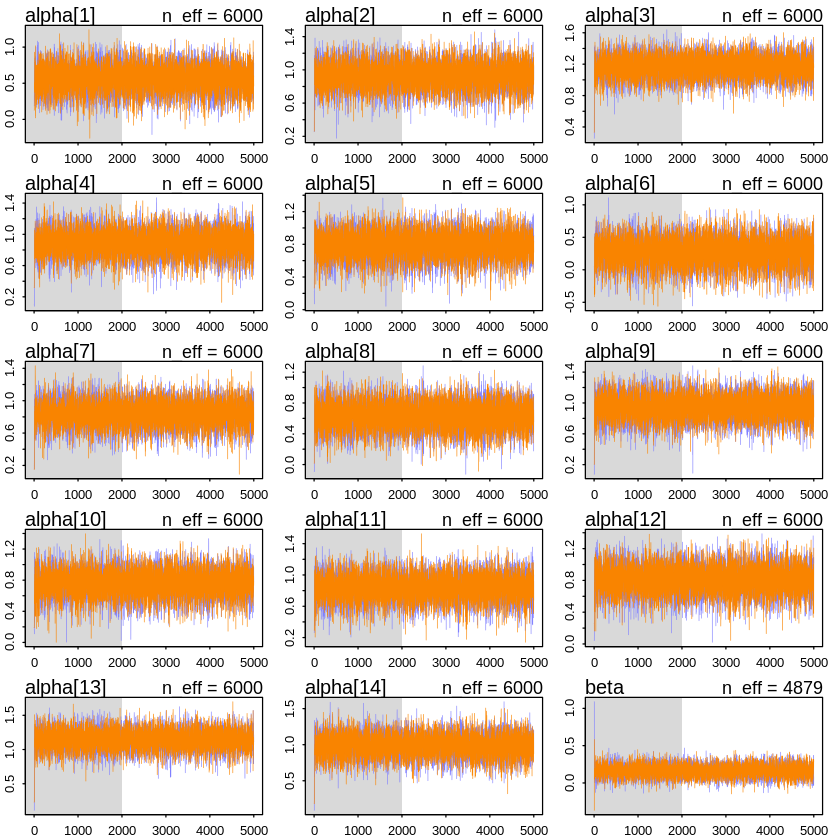

In [52]:
plot(m2)

In [53]:
precis(m2, depth = 2)

          Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
alpha[1]  0.57   0.19       0.26       0.88  6000    1
alpha[2]  0.93   0.17       0.67       1.20  6000    1
alpha[3]  1.17   0.14       0.93       1.39  6000    1
alpha[4]  0.89   0.17       0.61       1.16  6000    1
alpha[5]  0.79   0.17       0.50       1.04  6000    1
alpha[6]  0.27   0.23      -0.10       0.62  6000    1
alpha[7]  0.84   0.17       0.59       1.12  6000    1
alpha[8]  0.63   0.18       0.34       0.93  6000    1
alpha[9]  0.94   0.17       0.68       1.21  6000    1
alpha[10] 0.76   0.18       0.48       1.05  6000    1
alpha[11] 0.83   0.17       0.56       1.11  6000    1
alpha[12] 0.81   0.18       0.54       1.12  6000    1
alpha[13] 1.14   0.15       0.92       1.40  6000    1
alpha[14] 0.99   0.16       0.74       1.25  6000    1
beta      0.16   0.09       0.01       0.30  4879    1

In [54]:
precis(m3, depth = 2)

Warning message in precis(m3, depth = 2):
“There were 1282 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”

          Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
alpha[1]  0.78   0.16       0.53       0.96     8 1.19
alpha[2]  0.89   0.11       0.72       1.08   318 1.01
alpha[3]  0.99   0.12       0.82       1.20    33 1.05
alpha[4]  0.88   0.12       0.67       1.05    35 1.04
alpha[5]  0.85   0.12       0.64       1.00    14 1.10
alpha[6]  0.69   0.21       0.39       0.95     6 1.25
alpha[7]  0.86   0.12       0.66       1.03    25 1.05
alpha[8]  0.79   0.14       0.57       0.97     8 1.19
alpha[9]  0.90   0.11       0.69       1.06  1424 1.01
alpha[10] 0.83   0.13       0.62       1.01    15 1.09
alpha[11] 0.86   0.12       0.66       1.02    16 1.07
alpha[12] 0.85   0.12       0.64       1.01    25 1.06
alpha[13] 0.98   0.12       0.81       1.19   101 1.03
alpha[14] 0.92   0.11       0.73       1.11  1405 1.00
beta      0.14   0.10      -0.01       0.28     7 1.29
mu_a      0.86   0.08       0.73       0.97    13 1.10
mu_b      0.10   0.54      -0.77       0.93  1988 1.00
sigma_a   

In [55]:
post.m3 <- extract.samples(m3)
str(post.m3)

List of 6
 $ alpha  : num [1:6000, 1:14] 0.688 0.582 0.619 0.743 0.516 ...
 $ beta   : num [1:6000(1d)] 0.252 0.254 0.222 0.168 0.07 ...
 $ mu_a   : num [1:6000(1d)] 0.754 0.799 0.859 0.842 0.899 ...
 $ mu_b   : num [1:6000(1d)] 0.614 0.211 0.169 -0.122 0.109 ...
 $ sigma_a: num [1:6000(1d)] 0.169 0.22 0.172 0.119 0.167 ...
 $ sigma_b: num [1:6000(1d)] 0.544 0.367 0.749 0.551 0.07 ...


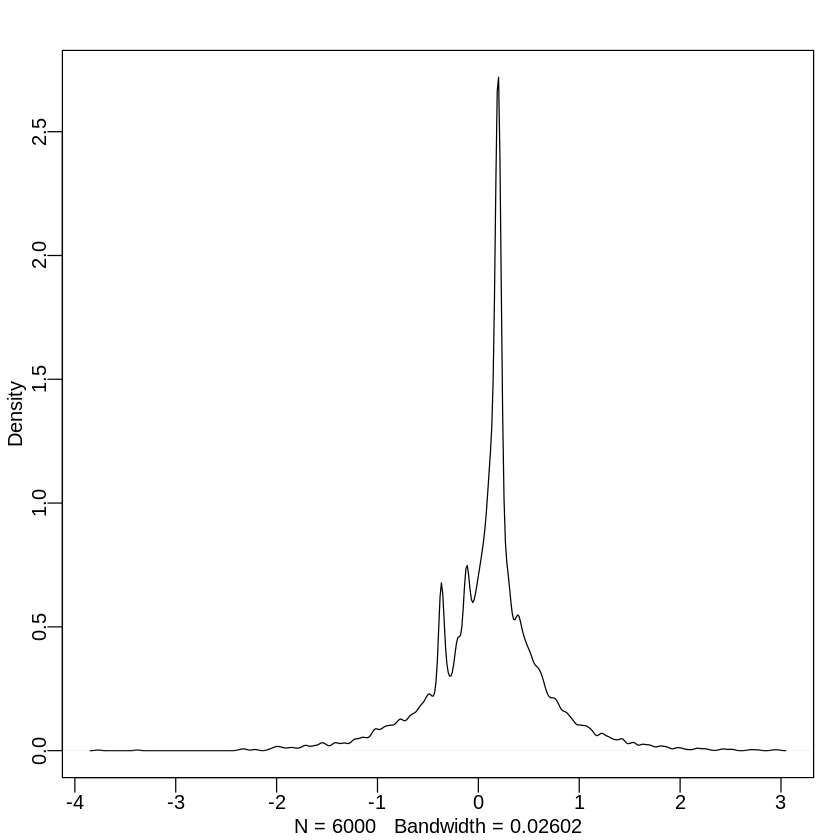

In [56]:
dens(post.m3$mu_b)

In [57]:
m4 <- map2stan(
    alist(
        goals ~ dpois(lambda),
        log(lambda) <- alpha[team] + beta[team]*home,
        alpha[team] ~ dnorm(mu_a,sigma_a),
        beta[team] ~ dnorm(mu_b,sigma_b),
        mu_a ~ dnorm(1,1),
        mu_b ~ dnorm(0,1),
        sigma_a ~ dcauchy(0,1),
        sigma_b ~ dcauchy(0,1)
    ),
    data = df,
    iter = 5000,
    warmup = 2000,
    chains = 2
)

In file included from /opt/conda/lib/R/library/BH/include/boost/config.hpp:39:0,
                 from /opt/conda/lib/R/library/BH/include/boost/math/tools/config.hpp:13,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file586d0f9d1d.cpp:8:
/opt/conda/lib/R/library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_REFERENCES
 ^
<command-line>:0:0: note: this is t

Warning message:
“There were 301 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


SAMPLING FOR MODEL 'goals ~ dpois(lambda)' NOW (CHAIN 1).

Gradient evaluation took 0.000274 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.74 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 1e-06 seconds (Warm-up)
               0.000877 seconds (Sampling)
               0.000878 seconds (Total)



Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Computing WAIC
Constructing posterior predictions


[ 6000 / 6000 ]


Warning message in map2stan(alist(goals ~ dpois(lambda), log(lambda) <- alpha[team] + :
“There were 301 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”

In [58]:
m5 <- map2stan(
    alist(
        goals ~ dpois(lambda),
        log(lambda) <- alpha[team] + beta * home,
        alpha[team] ~ dnorm(mu_a,sigma_a),
        beta ~ dnorm(0,1),
        mu_a ~ dnorm(1,1),
        sigma_a ~ dcauchy(0,1)
    ),
    data = df,
    iter = 5000,
    warmup = 2000,
    chains = 2
)

In file included from /opt/conda/lib/R/library/BH/include/boost/config.hpp:39:0,
                 from /opt/conda/lib/R/library/BH/include/boost/math/tools/config.hpp:13,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file5869b08352.cpp:8:
/opt/conda/lib/R/library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_REFERENCES
 ^
<command-line>:0:0: note: this is t

Warning message:
“There were 80 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


SAMPLING FOR MODEL 'goals ~ dpois(lambda)' NOW (CHAIN 1).

Gradient evaluation took 0.00025 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.5 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 1e-06 seconds (Warm-up)
               0.000774 seconds (Sampling)
               0.000775 seconds (Total)



Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Computing WAIC
Constructing posterior predictions


[ 6000 / 6000 ]


Warning message in map2stan(alist(goals ~ dpois(lambda), log(lambda) <- alpha[team] + :
“There were 80 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”

In [66]:
dnbinom

function (x, size, prob, mu, log = FALSE) 
{
    if (!missing(mu)) {
        if (!missing(prob)) 
            stop("'prob' and 'mu' both specified")
        .Call(C_dnbinom_mu, x, size, mu, log)
    }
    else .Call(C_dnbinom, x, size, prob, log)
}
<bytecode: 0x4673690>
<environment: namespace:stats>

In [71]:
123

[1] 123

In [70]:
m6 <- map2stan(
    alist(
        goals ~ dgampois(lambda, shape),
        log(lambda) <- alpha[team] + beta * home,
        alpha[team] ~ dnorm(mu_a,sigma_a),
        shape ~ dnorm(0,5),
        beta ~ dnorm(0,1),
        mu_a ~ dnorm(1,1),
        sigma_a ~ dcauchy(0,1)
    ),
    data = df,
    iter = 5000,
    warmup = 2000,
    chains = 2
)

In file included from /opt/conda/lib/R/library/BH/include/boost/config.hpp:39:0,
                 from /opt/conda/lib/R/library/BH/include/boost/math/tools/config.hpp:13,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file5867f4fe1b0.cpp:8:
/opt/conda/lib/R/library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_REFERENCES
 ^
<command-line>:0:0: note: this is 

Warning message:
“There were 76 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


SAMPLING FOR MODEL 'goals ~ dgampois(lambda, shape)' NOW (CHAIN 1).

Gradient evaluation took 0.000582 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.82 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 1e-06 seconds (Warm-up)
               0.001679 seconds (Sampling)
               0.00168 seconds (Total)



Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Computing WAIC
Constructing posterior predictions


[ 6000 / 6000 ]


Warning message in map2stan(alist(goals ~ dgampois(lambda, shape), log(lambda) <- alpha[team] + :
“There were 76 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”

In [73]:
compare(m5, m6)

     WAIC pWAIC dWAIC weight    SE   dSE
m5  755.2  10.0   0.0      1 22.67    NA
m6 1035.0   6.3 279.8      0 22.32 27.11

In [123]:
precis(m4, depth = 2)

Warning message in precis(m4, depth = 2):
“There were 72 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”

          Mean StdDev lower 0.89 upper 0.89 n_eff Rhat
alpha[1]  0.74   0.14       0.52       0.97  1506 1.00
alpha[2]  0.88   0.13       0.69       1.10  1959 1.00
alpha[3]  1.00   0.14       0.78       1.22  1156 1.00
alpha[4]  0.87   0.13       0.67       1.08  2026 1.00
alpha[5]  0.82   0.13       0.61       1.01  2256 1.00
alpha[6]  0.64   0.17       0.39       0.92   967 1.01
alpha[7]  0.84   0.12       0.64       1.03  2209 1.00
alpha[8]  0.76   0.14       0.54       0.97  1204 1.00
alpha[9]  0.89   0.13       0.69       1.09  2300 1.00
alpha[10] 0.80   0.13       0.59       1.00  2203 1.00
alpha[11] 0.84   0.13       0.64       1.05  2093 1.00
alpha[12] 0.83   0.13       0.62       1.02  2553 1.00
alpha[13] 0.99   0.14       0.76       1.19  1235 1.00
alpha[14] 0.90   0.13       0.69       1.10  1861 1.00
beta[1]   0.12   0.15      -0.11       0.35   573 1.00
beta[2]   0.19   0.14      -0.02       0.40  1285 1.00
beta[3]   0.19   0.13      -0.01       0.41  1212 1.00
beta[4]   

# declare m3 the winner

In [187]:
post.m5 <- extract.samples(m5)


In [188]:
class(post.m5['alpha'][[1]])

[1] "matrix"

In [217]:
post.m5['beta'][[1]]

[1]  1.971121e-01  1.999569e-01  1.550580e-01  1.132826e-01  1.138255e-01
   [6]  1.912924e-01  2.424959e-01  1.568786e-01  1.187167e-01  3.117248e-01
  [11]  2.459065e-01  5.128106e-02  4.357104e-01  2.623862e-02  9.985039e-02
  [16]  2.703311e-01 -2.103726e-03  1.787100e-01  2.593330e-02  1.679152e-01
  [21]  1.306980e-01  1.125120e-01  7.173455e-02  2.840716e-01  1.134937e-01
  [26]  2.434003e-01  1.729375e-01  2.609552e-01  2.690950e-01  1.634230e-01
  [31]  1.737213e-01  1.229537e-01  2.515551e-01  3.043944e-02  1.514904e-01
  [36]  2.637279e-01  1.996756e-01  1.168782e-01  8.221869e-02  2.585147e-01
  [41]  6.544275e-04  1.470321e-01  1.969475e-01  1.159123e-01  8.142740e-02
  [46]  1.775305e-02  2.446345e-01  1.336689e-01  3.142811e-01  1.618037e-01
  [51] -1.140051e-02  1.023263e-01  1.374881e-01  2.050224e-01  5.045742e-02
  [56]  2.604460e-01  3.128560e-01  1.839744e-01  1.316131e-01  1.281377e-01
  [61]  2.088254e-01  1.341423e-01  3.461899e-01  1.117085e-01  3.139497e-01
  [66]  2.743425e-01  2.828793e-01  1.961762e-01  2.856058e-01 -6.265477e-02
  [71]  2.989456e-01  1.975920e-01  2.057228e-01  1.487766e-01  2.255777e-01
  [76]  3.909731e-02  1.448088e-01  2.410586e-01  4.358800e-01  1.850521e-01
  [81]  6.488780e-02  3.123802e-02  1.990486e-01  2.261188e-01  1.892975e-01
  [86]  9.534971e-02  2.472850e-01  7.999289e-02  3.118397e-01  1.502303e-01
  [91]  1.065333e-01  1.503902e-01  1.168782e-01  6.932741e-02  1.561178e-01
  [96]  1.251795e-01  1.747961e-01  1.130726e-01  1.151639e-01 -1.143815e-02
 [101]  9.272615e-02  1.866042e-01  2.362482e-01  2.443373e-01  1.210860e-01
 [106]  2.331595e-01  1.219086e-01  2.867353e-01  2.062686e-01  2.634983e-01
 [111]  2.506518e-01  2.320295e-01  6.790065e-02  1.630874e-01  2.113620e-01
 [116]  1.253835e-01  1.573586e-01  8.992747e-02  1.689504e-01  1.664129e-01
 [121]  4.659282e-01  1.284432e-01  1.443071e-01  1.317651e-01  2.168229e-01
 [126]  2.563181e-01  1.168782e-01  9.358882e-02  1.855036e-01  2.479469e-01
 [131]  1.495713e-02  2.395823e-01  2.758264e-01  2.620996e-01  2.133013e-01
 [136]  9.928882e-02  2.095193e-01  1.994942e-01  3.018397e-01  1.004380e-01
 [141]  8.650357e-02  2.348593e-01  1.736233e-01  8.524548e-02  1.122661e-01
 [146]  2.172679e-01  1.829572e-01  2.842096e-01  1.944827e-01  1.399600e-01
 [151]  1.360045e-01  2.330924e-01  7.754336e-02  1.958958e-01  1.023173e-01
 [156]  3.084297e-01  1.797555e-01 -4.344579e-02  2.209038e-01  4.420899e-02
 [161]  1.036749e-02  6.065542e-02  8.866388e-02  1.523345e-02  2.186251e-01
 [166]  1.460609e-01  1.361222e-01  5.936076e-02  2.750772e-01  2.282719e-01
 [171]  1.393180e-01  2.059587e-01 -8.347236e-02  1.968933e-01  1.978553e-01
 [176]  8.910007e-02  5.995553e-02  2.973055e-02  8.166874e-02  1.684708e-01
 [181]  1.601973e-01  1.811721e-01  2.015000e-01  3.704270e-01  1.658889e-01
 [186]  7.490960e-02  1.578612e-01  2.273833e-01  1.345224e-01  1.026410e-01
 [191]  2.194597e-01 -1.052155e-01  2.438327e-01  1.542032e-01  1.742056e-01
 [196]  1.454651e-01  8.545980e-02  1.944900e-01  2.171143e-01  4.402099e-02
 [201]  2.082071e-01  1.708936e-01  3.386932e-01  1.144713e-01  6.777917e-02
 [206]  2.446645e-01  1.374475e-01  1.913242e-01  1.749434e-01  7.792709e-02
 [211]  5.618249e-02  1.679418e-01  3.755034e-01  1.894101e-01  1.695359e-02
 [216]  9.037492e-02  8.680680e-02  9.634105e-02  9.696183e-02  1.534152e-01
 [221]  1.622164e-01  9.772961e-02  2.526390e-01  2.623494e-01  6.289098e-02
 [226]  1.680089e-01  4.414060e-02  3.829515e-02  2.948880e-01  1.231562e-01
 [231]  2.431638e-01  1.814376e-01  2.949388e-01  2.361673e-01  8.353953e-02
 [236]  3.257360e-01  2.889476e-01  9.083034e-02  2.401802e-01  2.331563e-01
 [241]  2.277327e-01  2.527818e-01 -1.848685e-02  2.502585e-01  2.219438e-01
 [246]  1.639533e-01  1.865186e-01  2.312975e-01  2.279208e-01  1.532468e-01
 [251]  2.272913e-01  1.814960e-01  2.371823e-01  1.716820e-01  6.635117e-02
 [256]  1.147602e-01  6.314624e-02  6.584027e-02  1.168782e-01  1.211438e-01

In [325]:
# predict the last game of the season
a <- rpois(n = 5000, lambda = exp(post.m5['alpha'][[1]][,7] + post.m5['beta'][[1]]))
b <- rpois(n = 5000, lambda = exp(post.m5['alpha'][[1]][,6]))
res <- a - b

In [328]:
tie <- sum(res == 0)
loss <- sum(res < 0)
win <- sum(res > 0)
final_res <- c(win, tie, loss)
final_res

[1] 2835  837 1328

In [332]:

final_res <- final_res / sum(final_res)
final_res <- 1/ final_res
final_res

[1] 1.763668 5.973716 3.765060

In [238]:
a - b

[1]  3 -1 -3 -2 -1  4 -1 -2 -2 -4 -3  0 -1  0 -1 -3 -1  1  1 -1 -2 -5  1  1 -1
[26]  2  1 -1  0 -2  0  1  0  0  0 -1 -3  5  0  2 -2 -1  2  1 -4 -4 -1 -2 -2  0

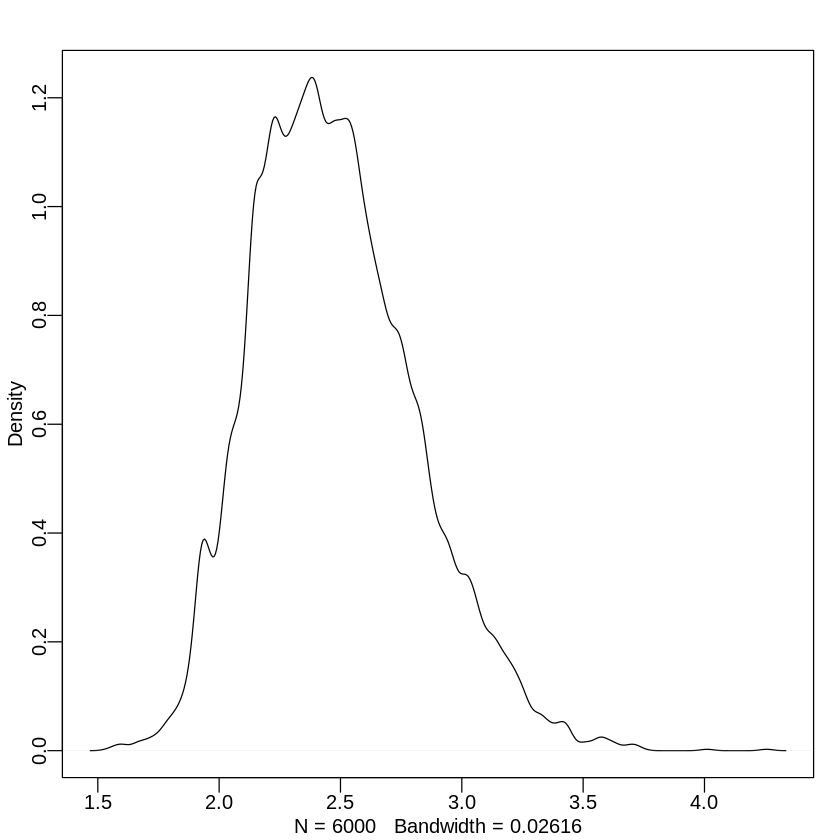

In [175]:
dens(exp(post.m3['alpha'][[1]][,14]))

Warning message in precis(m5, depth = 2):
“There were 205 divergent iterations during sampling.
Check the chains (trace plots, n_eff, Rhat) carefully to ensure they are valid.”

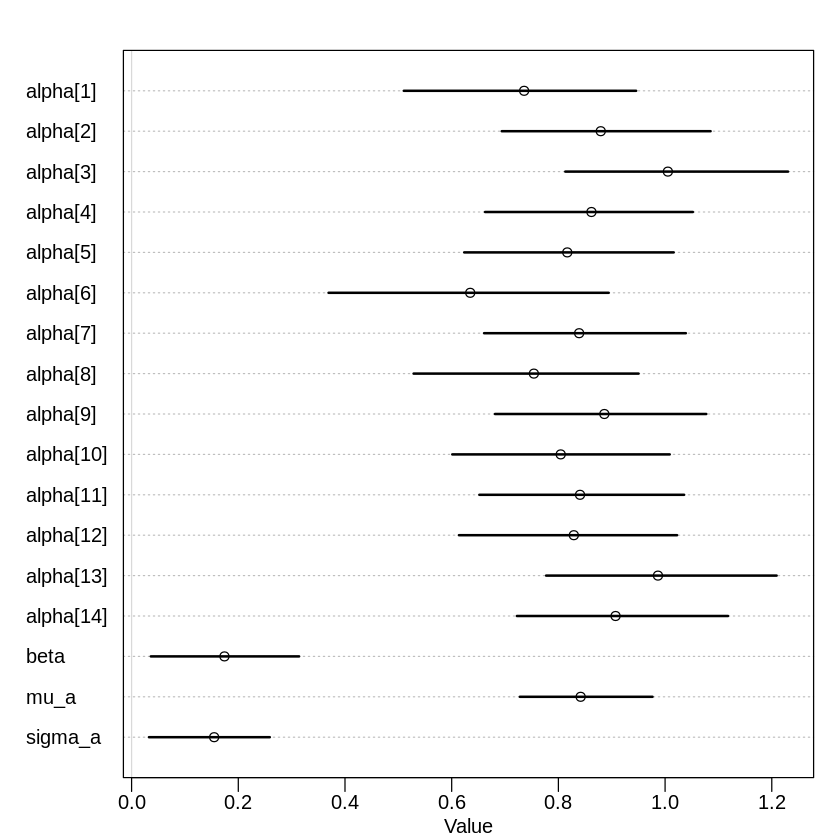

In [190]:
plot(precis(m5, depth = 2))

In [191]:
stancode(m5)

data{
    int<lower=1> N;
    int<lower=1> N_team;
    int goals[N];
    int team[N];
    real home[N];
}
parameters{
    vector[N_team] alpha;
    real beta;
    real mu_a;
    real<lower=0> sigma_a;
}
model{
    vector[N] lambda;
    sigma_a ~ cauchy( 0 , 1 );
    mu_a ~ normal( 1 , 1 );
    beta ~ normal( 0 , 1 );
    alpha ~ normal( mu_a , sigma_a );
    for ( i in 1:N ) {
        lambda[i] = alpha[team[i]] + beta * home[i];
    }
    goals ~ poisson_log( lambda );
}
generated quantities{
    vector[N] lambda;
    real dev;
    dev = 0;
    for ( i in 1:N ) {
        lambda[i] = alpha[team[i]] + beta * home[i];
    }
    dev = dev + (-2)*poisson_log_lpmf( goals | lambda );
}


In [281]:
teams

[1] Brynäs     Djurgården Färjestad  Frölunda   HV71       Karlskrona
 [7] Linköping  Luleå      Malmö      Mora       Örebro     Rögle     
[13] Skellefteå Växjö     
14 Levels: Brynäs Djurgården Färjestad Frölunda HV71 Karlskrona ... Växjö

In [317]:
m <- exp(post.m5['alpha'][[1]])
df_borta <- data.frame(m)
colnames(df_borta) <- teams
colSums(df_borta)/ nrow(df_borta)

Brynäs Djurgården  Färjestad   Frölunda       HV71 Karlskrona  Linköping 
  2.107881   2.427663   2.758106   2.385271   2.280133   1.914535   2.330136 
     Luleå      Malmö       Mora     Örebro      Rögle Skellefteå      Växjö 
  2.144367   2.444153   2.253102   2.334510   2.309108   2.708549   2.497084

In [318]:
m <- post.m5['alpha'][[1]]
beta <- post.m5['beta'][[1]]

for (i in 1:ncol(m))
    {
        m[,i] = m[,i] + beta
    }
df_hemma <- data.frame(exp(m))
colnames(df_hemma) <- teams
colSums(df_hemma)/ nrow(df_hemma)

Brynäs Djurgården  Färjestad   Frölunda       HV71 Karlskrona  Linköping 
  2.508451   2.887942   3.282502   2.837650   2.713782   2.277960   2.772910 
     Luleå      Malmö       Mora     Örebro      Rögle Skellefteå      Växjö 
  2.551434   2.908209   2.682295   2.778998   2.747232   3.222203   2.969947

In [322]:
get_odds <- function(df_hemma, df_borta, hemma, borta)
{
    print(head(select(df_hemma,hemma)))
}

get_odds(df_hemma, df_borta, "Linköping", "Brynäs")

ERROR: Error: All select() inputs must resolve to integer column positions.
The following do not:
*  hemma


In [75]:
library(dplyr)
df <- read.csv('2017_2018.csv')
df

DATUM,HEMMA,BORTA,HS,X.,VS,DEC,PERIOD,ARENA,ATT
2017-11-05,Linköping,Karlskrona,5,-,2,Reg,"2-0, 1-1, 2-1",Saab Arena,4503
2017-11-04,Växjö,Rögle,3,-,0,Reg,"0-0, 1-0, 2-0",Vida Arena,4315
2017-11-04,Brynäs,Mora,5,-,2,Reg,"3-0, 1-2, 1-0",Gavlerinken Arena,5735
2017-11-04,Färjestad,Djurgården,2,-,1,Reg,"1-0, 0-0, 1-1",Löfbergs Arena,8500
2017-11-04,Skellefteå,Malmö,4,-,2,Reg,"2-0, 1-2, 1-0",Skellefteå Kraft Arena,5085
2017-11-04,HV71,Frölunda,5,-,4,Reg,"1-0, 2-3, 2-1",Kinnarps Arena,7000
2017-11-03,Rögle,Växjö,3,-,4,Reg,"1-3, 1-0, 1-1",Lindab Arena,3755
2017-11-03,Djurgården,Färjestad,3,-,1,Reg,"2-0, 0-1, 1-0",Hovet,8094
2017-11-02,Luleå,HV71,3,-,2,Reg,"0-0, 2-1, 1-1",Coop Norrbotten Arena,5046
2017-11-02,Mora,Malmö,1,-,3,Reg,"0-1, 0-1, 1-1",Jalas Arena,4119
